In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import logistic
from scipy.special import logit

import torch
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset
from torch.cuda.amp import autocast, GradScaler

if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Train with GPU support.")
else:
    device = torch.device('cpu')
    print("No GPU found, train with CPU support.")

import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt


# own utils
from utils.graph import *
from utils.tram_models import *
from utils.tram_model_helpers import *
from utils.tram_data import *
from utils.continous import *
from utils.sampling_tram_data import *

Train with GPU support.


# 1. Experiments and Paths

In [2]:
experiment_name = "tramdagpaper_exp6_1_linearDGP_ls_std"   ## <--- set experiment name
seed=42
np.random.seed(seed)

DATA_PATH = "/home/bule/TramDag/data"
LOG_DIR="/home/bule/TramDag/dev_experiment_logs"
EXPERIMENT_DIR = os.path.join(LOG_DIR, experiment_name)
os.makedirs(EXPERIMENT_DIR,exist_ok=True)

# 2.  Data

- same experiment as in https://arxiv.org/pdf/2503.16206 6.1 Conitnous Case
- provide data in the form of a pandas dataframe, if there are iamges add the paths to each image to the df

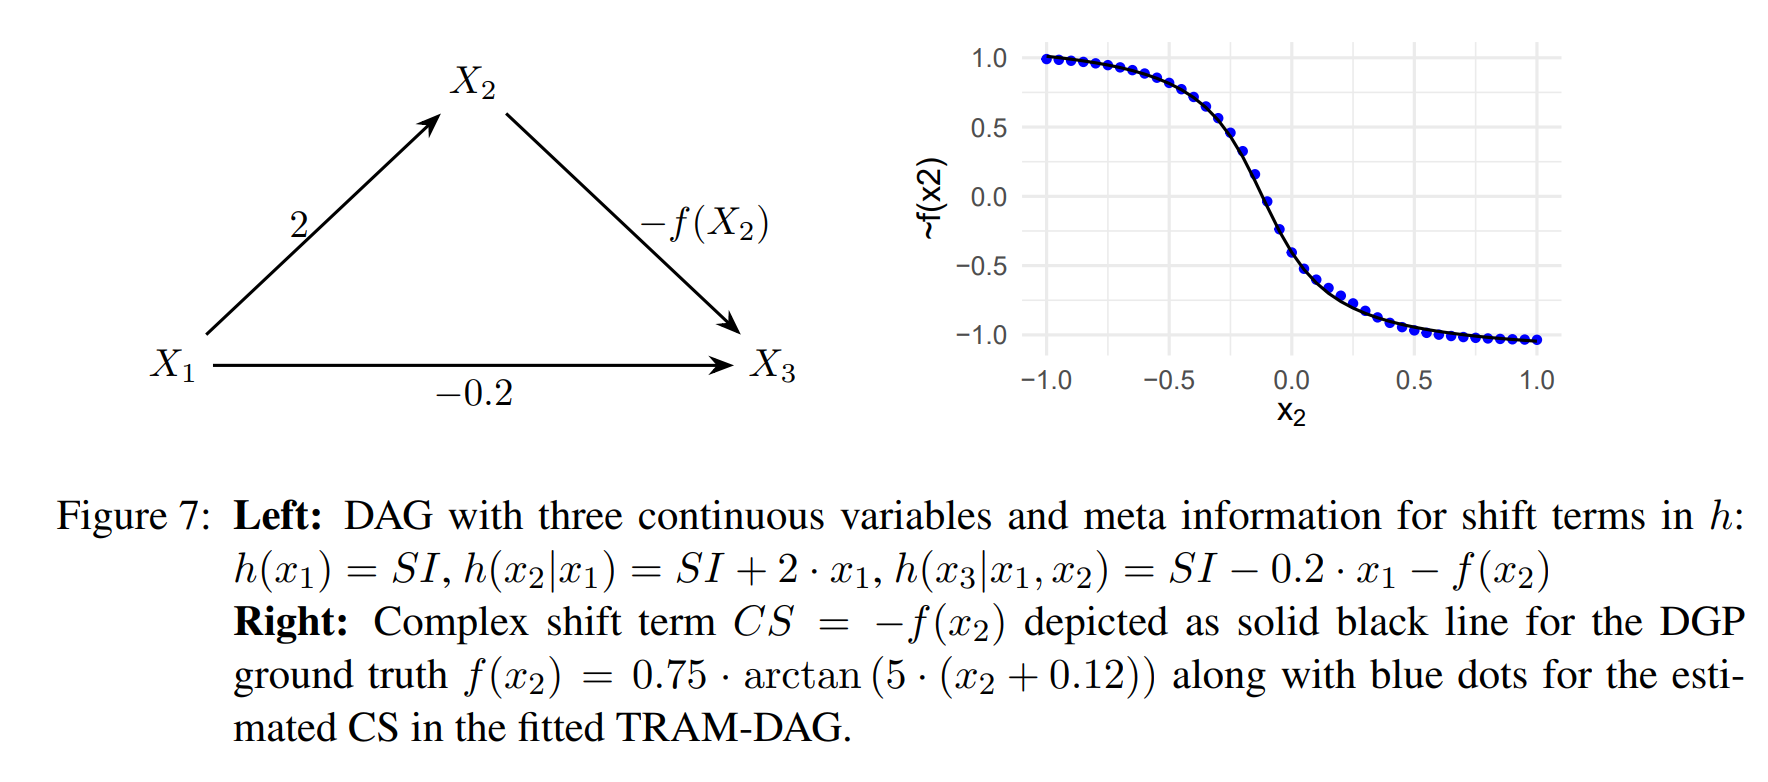

they made 3 experiments:
1. Linear-shift DGP and linear-shift model 
2. Complex-shift DGP and complex-shift model
3. Linear-shift DGP and complex-shift model 

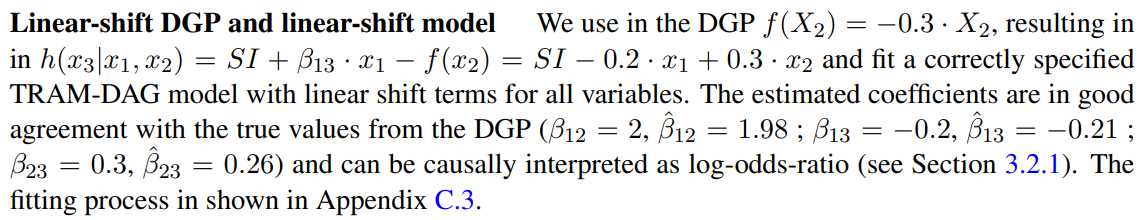

Setting Seed: 42
Loaded data from /home/bule/TramDag/dev_experiment_logs/tramdagpaper_exp6_1_linearDGP_ls_std/tramdagpaper_exp6_1_linearDGP_ls_std.csv


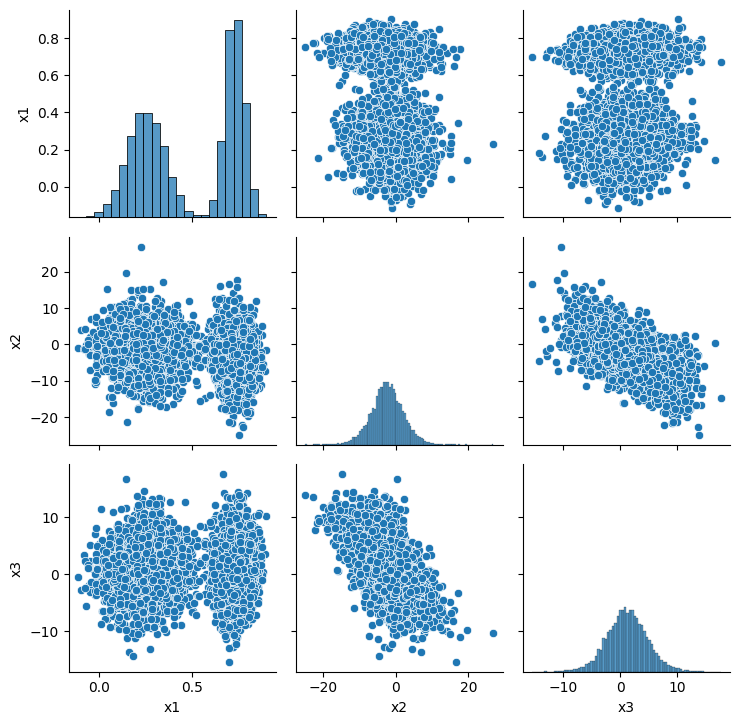

In [3]:
# 1. Linear-shift DGP and linear-shift model 
def f(x):
    return 0.3*x  

def dgp(n_obs, doX=[None, None, None], seed=-1):
    if seed > 0:
        np.random.seed(seed)
        print(f"Setting Seed: {seed}")
    
    # Generate x1 from a 2-component GMM
    
    # h(x1)= SI 
    
    
    if doX[0] is None:
        x1_A = np.random.normal(0.25, 0.1, n_obs)
        x1_B = np.random.normal(0.73, 0.05, n_obs)
        mix = np.random.choice([0, 1], size=n_obs)
        x1 = np.where(mix == 0, x1_A, x1_B)
    else:
        x1 = np.full(n_obs, doX[0])



    # Fz(z)=Fy(y)
    # Fz(h(y|x))=Fy(y)    | z= h(y|x)

    # Generate x2
    
    # h(x2|x1)= Bernsteinpol(x2) + beta2 * x1        | bernsteinpol is just linearized assumed with a constant factor say 0.42
    # h(x2|x1)= 0.42*x2 + beta2 * x1                 | replace h(x2|x1) with z
    # z       = 0.42*x2 + beta2 * x1                 | reformulate to x2
    # x2      = (z-beta2 * x1 )/0.42                 | sample z from standart logistic via uniform and logit(np.random.uniform(size=n_obs))
    # x2      = (z-beta2 * x1 )/0.42                 | set beta = 2 (on the edge of the graph)
    # x2      = (z-2 * x1 )/0.42                     |
    
    if doX[1] is None:
        u2 = np.random.uniform(size=n_obs)
        x2_dash = logit(u2)
        x2 = (x2_dash - 2 * x1) / 0.42
    else:
        x2 = np.full(n_obs, doX[1])

    # Generate x3
    
    # h(x3|x2,x1)= Bernsteinpol(x3) + beta3 * x1 + f(X2)        | bernsteinpol is just linearized assumed with a constant factor say 0.63
    # h(x3|x2,x1)= 0.63*x3 + beta3 * x1          + f(X2)        | replace h(x2|x1) with z
    # z          = 0.63*x3 + beta3 * x1          + f(X2)        | reformulate to x2
    # x3         = (z-beta3 * x1 -f(X2))/0.63                   | sample z from standart logistic via uniform and logit(np.random.uniform(size=n_obs))
    # x3         = (z-beta3 * x1 -f(X2))/0.63                   | set beta = -0.2 (on the edge of the graph)
    # x3         = (z+0.2 * x1   -f(X2))/0.63                   | 

    
    if doX[2] is None:
        u3 = np.random.uniform(size=n_obs)
        x3_dash = logit(u3)
        x3 = (x3_dash + 0.2 * x1 - f(x2)) / 0.63
    else:
        x3 = np.full(n_obs, doX[2])

    df = pd.DataFrame({'x1': x1, 'x2': x2, 'x3': x3})
    return df

n_obs=1_000

df = dgp(n_obs=n_obs, seed=42)

EXP_DATA_PATH=os.path.join(EXPERIMENT_DIR, f"{experiment_name}.csv")


if not os.path.exists(EXP_DATA_PATH):
    df = dgp(n_obs=n_obs)

    print(df.head())
    df.to_csv(EXP_DATA_PATH, index=False)

else:
    df = pd.read_csv(EXP_DATA_PATH)
    print(f"Loaded data from {EXP_DATA_PATH}")


sns.pairplot(df)
plt.suptitle("", y=1.02)
plt.tight_layout()
plt.show()

## 2.1 train test split

In [4]:

# 1. Split the data
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# 2. Compute quantiles from training data
quantiles = train_df.quantile([0.025, 0.975])
min_vals = quantiles.loc[0.025]
max_vals = quantiles.loc[0.975]

# 3. Normalize all sets using training quantiles
def normalize_with_quantiles(df, min_vals, max_vals):
    return (df - min_vals) / (max_vals - min_vals)

# train_df = normalize_with_quantiles(train_df, min_vals, max_vals)
# val_df = normalize_with_quantiles(val_df, min_vals, max_vals)
# test_df = normalize_with_quantiles(test_df, min_vals, max_vals)

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")


Train size: 8000, Validation size: 1000, Test size: 1000


# 3. Define graph Structure

- define graph and which shift and intercept terms to use


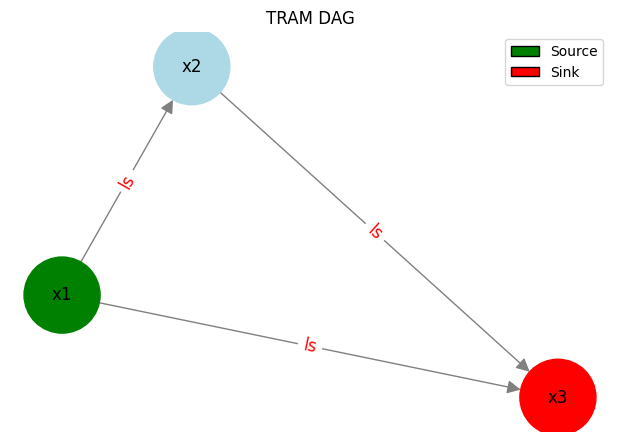

In [5]:
# describe if data is continous or  ordinal  ['cont', 'ord','other']
# note that other data than tabular can only be used as source 

# TODO support for interactions in CI model eg CI_1

# Example 1 dgp tramdag paper  3x3: 
data_type={'x1':'cont','x2':'cont','x3':'cont'}  # continous , images , ordinal
adj_matrix = np.array([
    [ "0", "ls", "ls"],  # A -> B (cs), A -> C (ls)
    [ "0", "0", "ls"],  # B -> D (ls)
    [ "0", "0", "0"],  # C -> D (cs)
], object)

# its also possible to have ci11 and ci12 etc to inlcude multiple varibales for a network for the intercept. aswell as for cs name it with ci11 ci12

plot_seed=5
plot_dag(adj_matrix,data_type, seed=plot_seed)

# 4. Configuration for the Models

- all SI and LS model are generated outmatically since these are shallow NN's
- CI and CS have to be defined by the User and can be Passed for each model, -> generate default networks which are generated automaitcally

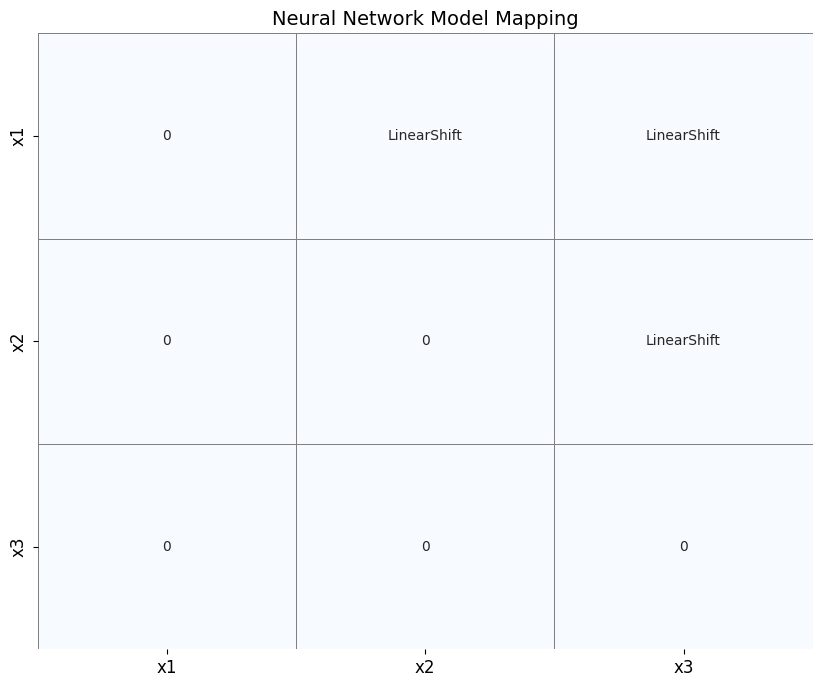

In [6]:
# check if there are Ci or Compelx shifts in the models. If yes define the modelnames
nn_names_matrix= create_nn_model_names(adj_matrix,data_type)
plot_nn_names_matrix(nn_names_matrix,data_type)

In [7]:
#TODO : OPTION write config to a argparser to  and args object to pass datatypes

conf_dict=get_configuration_dict(adj_matrix,nn_names_matrix, data_type)
# write min max to conf dict
for i,node in enumerate(data_type.keys()):
    conf_dict[node]['min']=min_vals[i].tolist()   # <---- TODO add quanitle marker
    conf_dict[node]['max']=max_vals[i].tolist()
    

# write to file
CONF_DICT_PATH = os.path.join(EXPERIMENT_DIR, f"{experiment_name}_conf.json")
with open(CONF_DICT_PATH, 'w') as f:
    json.dump(conf_dict, f, indent=4)
    
print(f"Configuration saved to {CONF_DICT_PATH}")

conf_dict

Configuration saved to /home/bule/TramDag/dev_experiment_logs/tramdagpaper_exp6_1_linearDGP_ls_std/tramdagpaper_exp6_1_linearDGP_ls_std_conf.json


/tmp/ipykernel_310772/1695834966.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  conf_dict[node]['min']=min_vals[i].tolist()   # <---- TODO add quanitle marker
/tmp/ipykernel_310772/1695834966.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  conf_dict[node]['max']=max_vals[i].tolist()


{'x1': {'Modelnr': 0,
  'data_type': 'cont',
  'node_type': 'source',
  'parents': [],
  'parents_datatype': {},
  'transformation_terms_in_h()': {},
  'transformation_term_nn_models_in_h()': {},
  'min': 0.08584870576958688,
  'max': 0.8122044086990192},
 'x2': {'Modelnr': 1,
  'data_type': 'cont',
  'node_type': 'internal',
  'parents': ['x1'],
  'parents_datatype': {'x1': 'cont'},
  'transformation_terms_in_h()': {'x1': 'ls'},
  'transformation_term_nn_models_in_h()': {'x1': 'LinearShift'},
  'min': -11.525172445357219,
  'max': 6.681991225276698},
 'x3': {'Modelnr': 2,
  'data_type': 'cont',
  'node_type': 'sink',
  'parents': ['x1', 'x2'],
  'parents_datatype': {'x1': 'cont', 'x2': 'cont'},
  'transformation_terms_in_h()': {'x1': 'ls', 'x2': 'ls'},
  'transformation_term_nn_models_in_h()': {'x1': 'LinearShift',
   'x2': 'LinearShift'},
  'min': -5.8988260977775715,
  'max': 8.572311356930177}}

In [8]:
DEV_TRAINING=True
train_list=['x1','x2','x3']#['x1']#['x1','x2','x3']#,#,['x1','x2','x3'] # <-  set the nodes which have to be trained , useful if further training is required else lsit all vars

batch_size = 64#4112
epochs = 300  # <- if you want a higher numbe rof epochs, set the number higher and it loads the old model and starts from there
use_scheduler = True

In [9]:
# For each NODE 
for node in conf_dict:
    
    print(f'\n----*----------*-------------*--------------- Node: {node} ------------*-----------------*-------------------*--')
    
    ########################## 0. Skip nodes ###############################
    if node not in train_list:# Skip if node is not in train_list
        print(f"Skipping node {node} as it's not in the training list.")
        continue
    if (conf_dict[node]['node_type'] == 'source') and (conf_dict[node]['node_type'] == 'other'):# Skip unsupported types
        print(f"Node type : other , is not supported yet")
        continue

    ########################## 1. Setup Paths ###############################
    NODE_DIR = os.path.join(EXPERIMENT_DIR, f'{node}')
    os.makedirs(NODE_DIR, exist_ok=True)
    MODEL_PATH, LAST_MODEL_PATH, TRAIN_HIST_PATH, VAL_HIST_PATH = model_train_val_paths(NODE_DIR)

    ########################## 2. Create Model ##############################
    tram_model = get_fully_specified_tram_model(node, conf_dict, verbose=True).to(device)

    ########################## 3. Create Dataloaders ########################
    train_loader, val_loader = get_dataloader(node, conf_dict, train_df, val_df, batch_size=batch_size, verbose=True)

    
    
    
    ########################## 4. Load Model & History ######################
    if os.path.exists(MODEL_PATH) and os.path.exists(TRAIN_HIST_PATH) and os.path.exists(VAL_HIST_PATH):
        print("Existing model found. Loading weights and history...")
        tram_model.load_state_dict(torch.load(MODEL_PATH))

        with open(TRAIN_HIST_PATH, 'r') as f:
            train_loss_hist = json.load(f)
        with open(VAL_HIST_PATH, 'r') as f:
            val_loss_hist = json.load(f)

        start_epoch = len(train_loss_hist)
        best_val_loss = min(val_loss_hist)
        print(f"Continuing training from epoch {start_epoch}...")
    else:
        print("No existing model found. Starting fresh...")
        train_loss_hist, val_loss_hist = [], []
        start_epoch = 0
        best_val_loss = float('inf')

    # Skip if already trained
    if start_epoch >= epochs:
        print(f"Node {node} already trained for {epochs} epochs. Skipping.")
        continue

    ########################## 5. Optimizer & Scheduler ######################.
    
    ## <---------- TODO use standard SGD and no scheduler
    optimizer = torch.optim.AdamW(tram_model.parameters(), lr=0.1, eps=1e-8, weight_decay=1e-2)
    
    if use_scheduler:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
    else:
        scheduler = None

    ########################## 6. Min/Max Tensor #############################
    min_vals = torch.tensor(conf_dict[node]['min'], dtype=torch.float32).to(device)
    max_vals = torch.tensor(conf_dict[node]['max'], dtype=torch.float32).to(device)
    min_max = torch.stack([min_vals, max_vals], dim=0)

    ########################## 7. Training Loop ##############################

    if DEV_TRAINING:
        train_val_loop(
            start_epoch,
            epochs,
            tram_model,
            train_loader,
            val_loader,
            train_loss_hist,
            val_loss_hist,
            best_val_loss,
            device,
            optimizer,
            use_scheduler,
            scheduler,
            min_max,
            NODE_DIR,
            save_linear_shifts=True
        )


----*----------*-------------*--------------- Node: x1 ------------*-----------------*-------------------*--
>>>>>>>>>>>>  source node --> only  modelled only  by si
TramModel(
  (nn_int): SimpleIntercept(
    (fc): Linear(in_features=1, out_features=20, bias=False)
  )
)
>>>>>>>>>>>>  source node --> x in dataloader contains just 1s 
Existing model found. Loading weights and history...
Continuing training from epoch 1000...
Node x1 already trained for 300 epochs. Skipping.

----*----------*-------------*--------------- Node: x2 ------------*-----------------*-------------------*--
>>>>>>>>>>>> No ci detected --> intercept defaults to si
>>> TRAM MODEL:
 TramModel(
  (nn_int): SimpleIntercept(
    (fc): Linear(in_features=1, out_features=20, bias=False)
  )
  (nn_shift): ModuleList(
    (0): LinearShift(
      (fc): Linear(in_features=1, out_features=1, bias=False)
    )
  )
)
Existing model found. Loading weights and history...
Continuing training from epoch 1000...
Node x2 already t

In [10]:
train_loader, val_loader = get_dataloader(node, conf_dict, train_df, val_df, batch_size=10, verbose=True)
next(iter(train_loader))


[[tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
  tensor([0.1230, 0.7582, 0.2376, 0.7002, 0.2042, 0.2419, 0.7516, 0.7329, 0.1454,
          0.7394]),
  tensor([  3.7564,   3.4305,  -0.9892,  -2.4319,  -0.0562,  -0.9885,  -9.2306,
           -1.6222,   6.0138, -10.6360])],
 tensor([ 2.4378, -2.0428,  3.3972,  1.0298, -0.1492, -0.7694, 10.7215,  1.3872,
         -5.9975,  1.2148])]

In [11]:
train_loader, val_loader = get_dataloader(node, conf_dict, train_df, val_df, batch_size=10, verbose=True)
next(iter(train_loader))
next(iter(val_loader))

[[tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
  tensor([0.1142, 0.7410, 0.6257, 0.3171, 0.1482, 0.2932, 0.1236, 0.1112, 0.7004,
          0.7158]),
  tensor([-0.0122, -3.4981, -0.1313,  4.1046, -1.3182, -3.0522,  0.1661, -2.7376,
          -0.6981, -5.1803])],
 tensor([-0.4203,  1.5883,  1.0734, -2.6740,  1.3666,  2.4203,  1.1553, -3.4175,
          2.8294,  4.1756])]

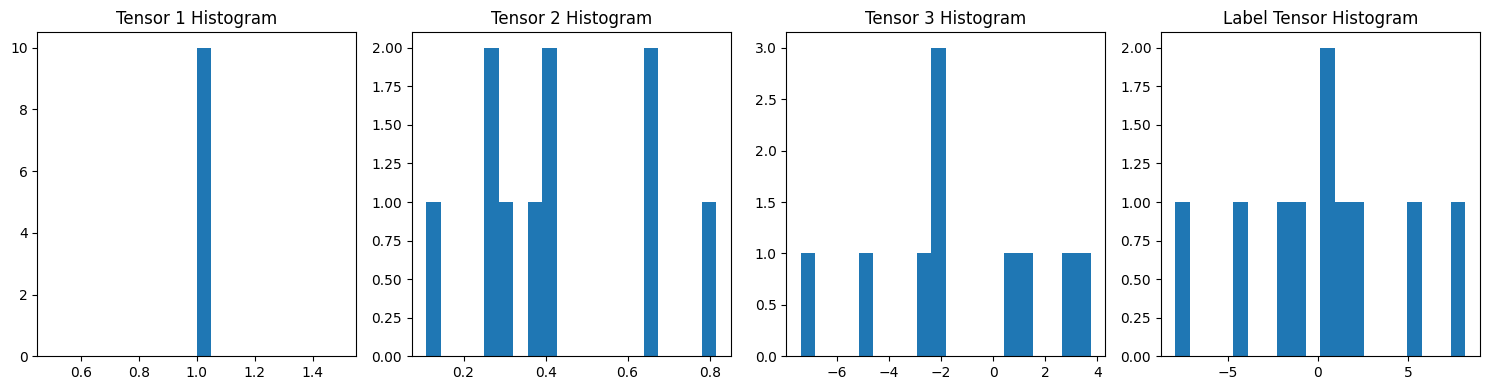

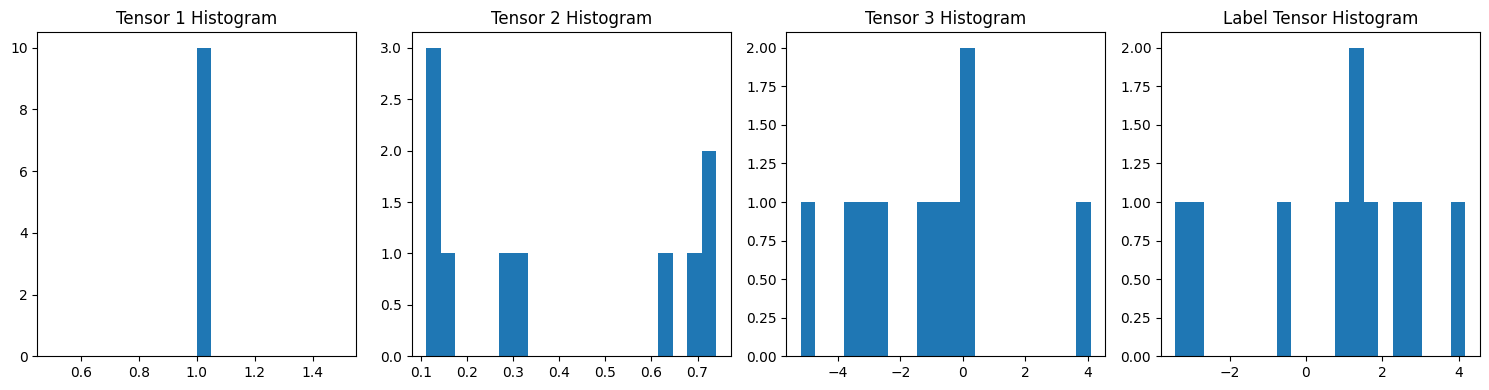

In [12]:

# Assuming this is how your data looks like
data, labels = next(iter(train_loader))  # or val_loader
tensor1, tensor2, tensor3_train = data  # Unpack the three input tensors

# Plot histograms
plt.figure(figsize=(15, 4))

plt.subplot(1, 4, 1)
plt.hist(tensor1.numpy(), bins=20)
plt.title("Tensor 1 Histogram")

plt.subplot(1, 4, 2)
plt.hist(tensor2.numpy(), bins=20)
plt.title("Tensor 2 Histogram")

plt.subplot(1, 4, 3)
plt.hist(tensor3_train.numpy(), bins=20)
plt.title("Tensor 3 Histogram")

plt.subplot(1, 4, 4)
plt.hist(labels.numpy(), bins=20)
plt.title("Label Tensor Histogram")

plt.tight_layout()
plt.show()



# Assuming this is how your data looks like
data, labels = next(iter(val_loader))  # or val_loader
tensor1, tensor2, tensor3 = data  # Unpack the three input tensors

# Plot histograms
plt.figure(figsize=(15, 4))

plt.subplot(1, 4, 1)
plt.hist(tensor1.numpy(), bins=20)
plt.title("Tensor 1 Histogram")

plt.subplot(1, 4, 2)
plt.hist(tensor2.numpy(), bins=20)
plt.title("Tensor 2 Histogram")

plt.subplot(1, 4, 3)
plt.hist(tensor3.numpy(), bins=20)
plt.title("Tensor 3 Histogram")

plt.subplot(1, 4, 4)
plt.hist(labels.numpy(), bins=20)
plt.title("Label Tensor Histogram")

plt.tight_layout()
plt.show()

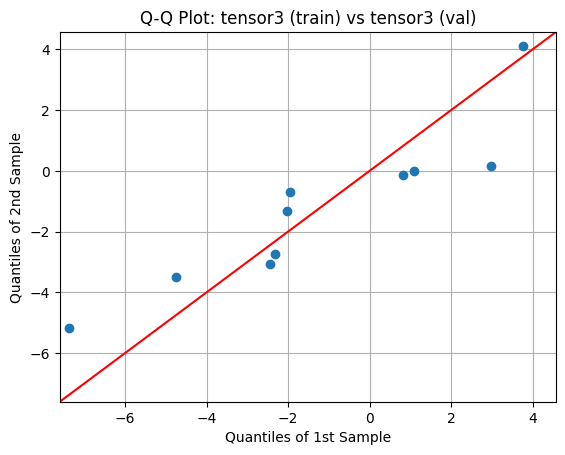

In [13]:

from statsmodels.graphics.gofplots import qqplot_2samples

qqplot_2samples(tensor3_train, tensor3, line='45')
plt.title("Q-Q Plot: tensor3 (train) vs tensor3 (val)")
plt.grid(True)
plt.show()

In [14]:
# [[tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
#   tensor([0.0737, 0.7634, 0.3469, 0.6916, 0.7227, 0.3493, 0.9001, 0.2211, 0.6545,
#           0.1304]),
#   tensor([ 3.0017, -2.0504,  1.2497, -3.6898, -6.3833, -7.1274, -1.4036,  2.1854,
#           -4.6354, -4.8516])],
#  tensor([-3.7115, -0.6047,  2.1268,  0.2091,  1.3839, -0.1416, 10.1945, -3.0409,
#           5.6472,  0.6839])]




# Train loader (x3):   0%|          | 0/800 [00:00<?, ?it/s]
# train_ints: tensor([[1.],
#         [1.],
#         [1.],
#         [1.],
#         [1.],
#         [1.],
#         [1.],
#         [1.],
#         [1.],
#         [1.]], device='cuda:0')
# train_shifts: [tensor([[0.3784],
#         [0.2984],
#         [0.3573],
#         [0.1439],
#         [0.6348],
#         [0.2041],
#         [0.6854],
#         [0.4416],
#         [0.7309],
#         [0.0962]], device='cuda:0'), tensor([[-1.4988],
#         [-6.5330],
#         [ 3.3841],
#         [-3.9710],
#         [-4.8871],
#         [-5.0423],
#         [-5.0601],
#         [ 2.8884],
#         [-7.1315],
#         [-2.7967]], device='cuda:0')]

In [15]:
h_train_list,h_val_list=[],[]
min_vals = torch.tensor(conf_dict[node]['min'], dtype=torch.float32).to(device)
max_vals = torch.tensor(conf_dict[node]['max'], dtype=torch.float32).to(device)
min_max = torch.stack([min_vals, max_vals], dim=0)
with torch.no_grad():
    for x, y in tqdm(train_loader, desc=f"Train loader ({node})", total=len(train_loader)):
        
        print(f'x_train before prp: {x}')
        
        y = y.to(device)
        int_input, shift_list = preprocess_inputs(x, device=device)
        
        print(f'train_ints: {int_input}')
        print(f'train_shifts: { shift_list}')
        
        y_pred = tram_model(int_input=int_input, shift_input=shift_list)
        
        
        
        h_train, _ = contram_nll(y_pred, y, min_max=min_max, return_h=True)
        h_train_list.extend(h_train.cpu().numpy())
        break

Train loader (x3):   0%|          | 0/80 [00:00<?, ?it/s]

x_train before prp: [tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), tensor([0.7304, 0.2430, 0.2112, 0.8497, 0.1644, 0.2149, 0.6845, 0.1111, 0.1349,
        0.7228]), tensor([ -4.3622,   4.3810, -12.8764,   3.7688,  -3.3389,  -1.4789,  -2.7400,
         -3.4280,   1.1684,  -1.1881])]
train_ints: tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
train_shifts: [tensor([[0.7304],
        [0.2430],
        [0.2112],
        [0.8497],
        [0.1644],
        [0.2149],
        [0.6845],
        [0.1111],
        [0.1349],
        [0.7228]], device='cuda:0'), tensor([[ -4.3622],
        [  4.3810],
        [-12.8764],
        [  3.7688],
        [ -3.3389],
        [ -1.4789],
        [ -2.7400],
        [ -3.4280],
        [  1.1684],
        [ -1.1881]], device='cuda:0')]


Train loader (x3):   0%|          | 0/80 [00:00<?, ?it/s]


<Axes: ylabel='Count'>

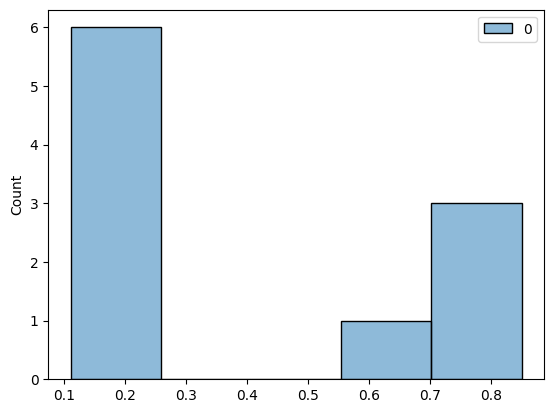

In [16]:
sns.histplot(shift_list[0].cpu().numpy())

<Axes: ylabel='Count'>

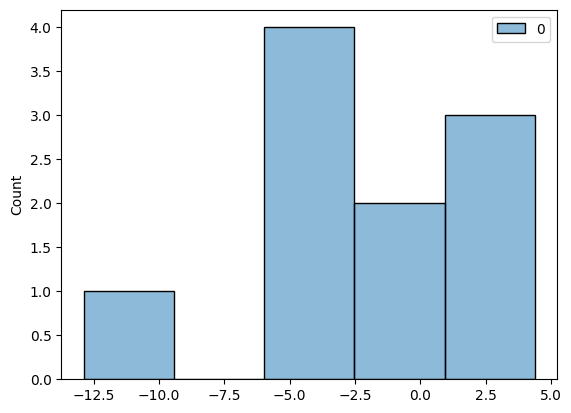

In [17]:
sns.histplot(shift_list[1].cpu().numpy())

In [18]:
# train 
# x1 [0.6936, 0.6746, 0.1884, 0.7264, 0.2224, 0.7052, 0.7999, 0.2882, 0.2764,0.6748]),
# x2 -5.0963, -2.4505,  3.2266,  2.4449, -1.6755,  2.1757, -3.3529,  1.8723, -3.1236, -5.4151])]


# val
#x1 [0.8062,   0.1937, 0.8431,     0.3957,   0.7756,  0.6807,
#x2 [-9.8430,  3.1572, -10.9185,   1.9638,  -6.9769,  -1.8807,   1.0953,

In [19]:
with torch.no_grad():
    for x, y in tqdm(val_loader, desc=f"Val loader ({node})", total=len(val_loader)):
        
        print(f'x_train before prp: {x}')
        y = y.to(device)
        int_input, shift_list = preprocess_inputs(x, device=device)
        
        print(f'val_ints: {int_input}')
        print(f'val_shifts: {shift_list}')

        y_pred = tram_model(int_input=int_input, shift_input=shift_list)
        h_val, _ = contram_nll(y_pred, y, min_max=min_max, return_h=True)
        h_val_list.extend(h_val.cpu().numpy())
        break

Val loader (x3):   0%|          | 0/10 [00:00<?, ?it/s]

x_train before prp: [tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), tensor([0.1142, 0.7410, 0.6257, 0.3171, 0.1482, 0.2932, 0.1236, 0.1112, 0.7004,
        0.7158]), tensor([-0.0122, -3.4981, -0.1313,  4.1046, -1.3182, -3.0522,  0.1661, -2.7376,
        -0.6981, -5.1803])]
val_ints: tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
val_shifts: [tensor([[0.1142],
        [0.7410],
        [0.6257],
        [0.3171],
        [0.1482],
        [0.2932],
        [0.1236],
        [0.1112],
        [0.7004],
        [0.7158]], device='cuda:0'), tensor([[-0.0122],
        [-3.4981],
        [-0.1313],
        [ 4.1046],
        [-1.3182],
        [-3.0522],
        [ 0.1661],
        [-2.7376],
        [-0.6981],
        [-5.1803]], device='cuda:0')]


<Axes: ylabel='Count'>

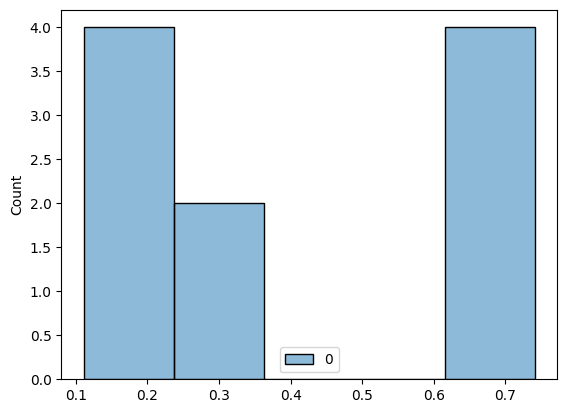

In [20]:
sns.histplot(shift_list[0].cpu().numpy())

# 6 Inspect Training

## 6.1 Loss vs epochs

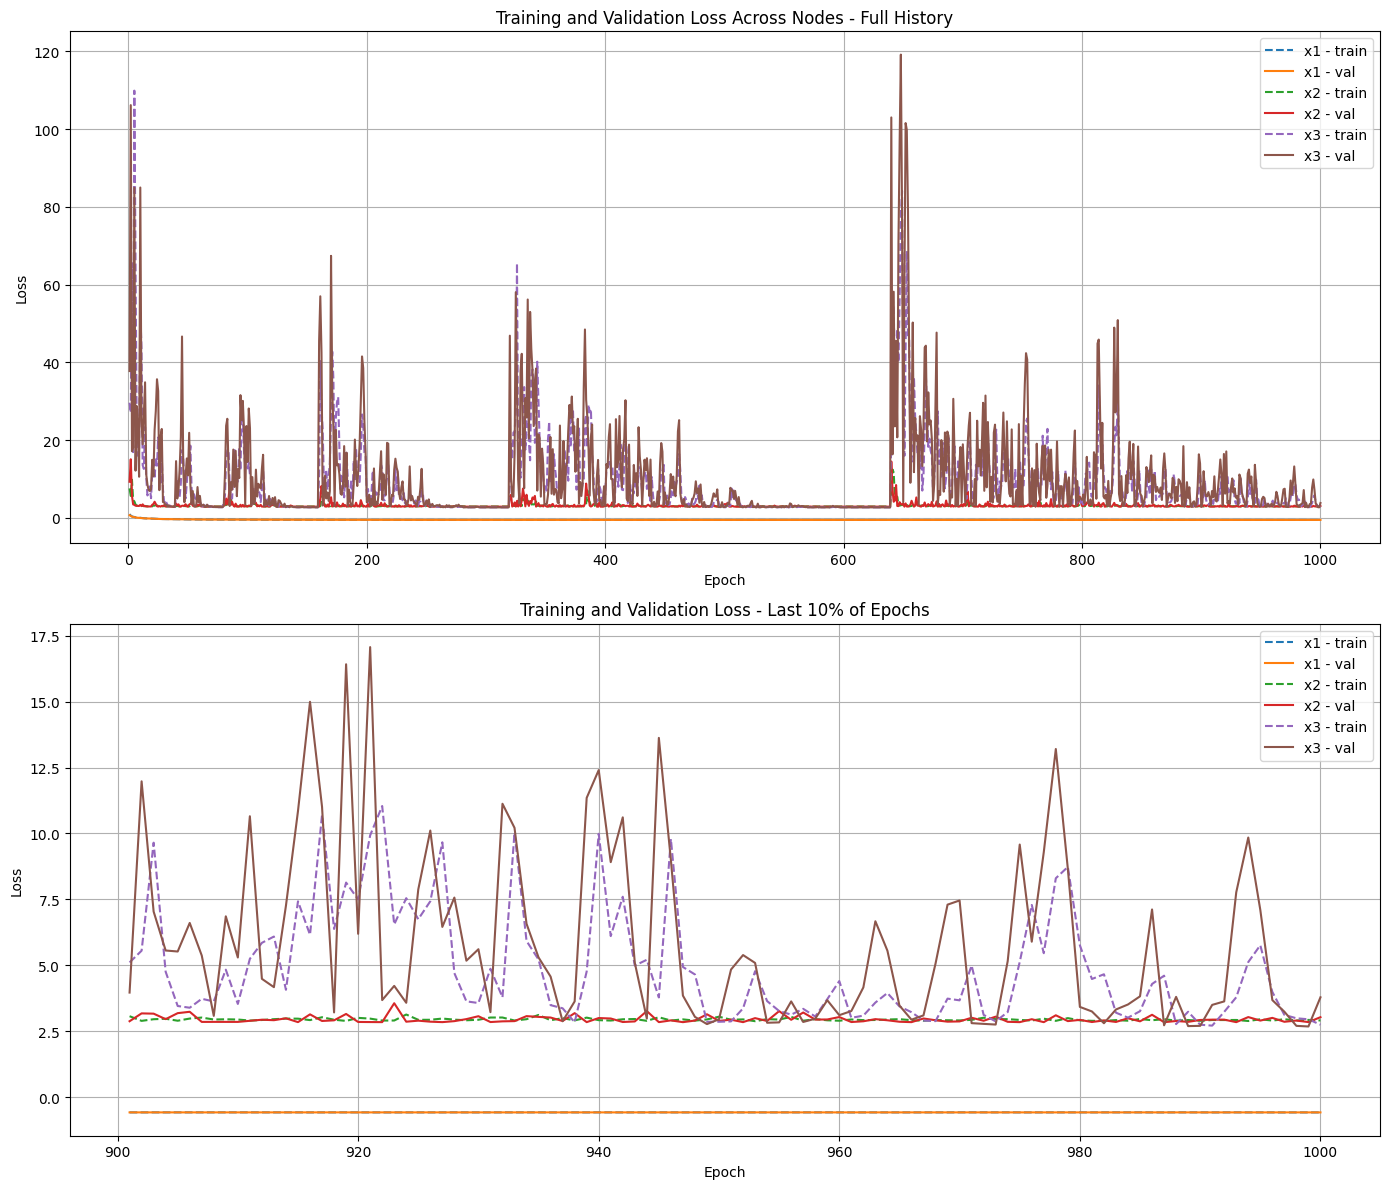

In [10]:
show_training_history(conf_dict,EXPERIMENT_DIR)

## 6.2 inspect transformation function for source nodes h()


----*----------*-------------*--------Inspect TRAFO Node: x1 ------------*-----------------*-------------------*--


h() for  x1:   0%|          | 0/1000 [00:00<?, ?it/s]

h() for  x1:   0%|          | 0/1000 [00:00<?, ?it/s]


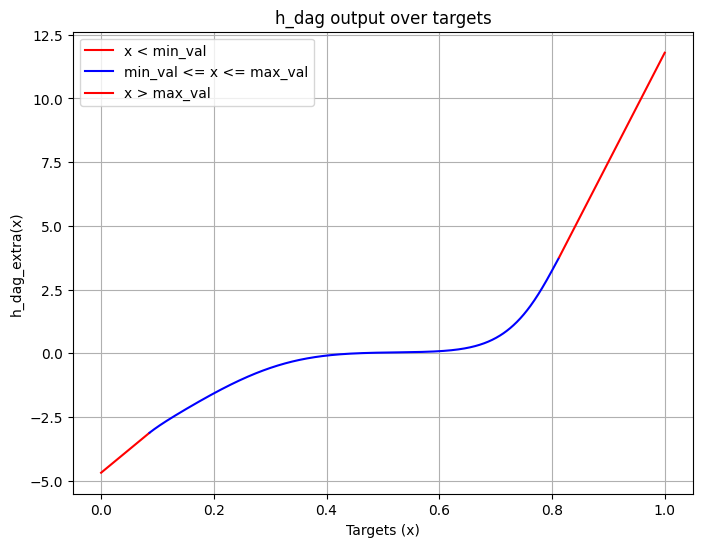


----*----------*-------------*--------Inspect TRAFO Node: x2 ------------*-----------------*-------------------*--
skipped.. since h does depend on parents and is different for every instance

----*----------*-------------*--------Inspect TRAFO Node: x3 ------------*-----------------*-------------------*--
skipped.. since h does depend on parents and is different for every instance


In [11]:
show_hdag_for_source_nodes(conf_dict,EXPERIMENT_DIR,device=device,xmin_plot=0,xmax_plot=1) # TODO for other nodes funciton


----*----------*-------------*--------h(data) should be standard logistic: x1 ------------*-----------------*-------------------*--


Val loader (x1): 100%|██████████| 2/2 [00:00<00:00,  3.36it/s]


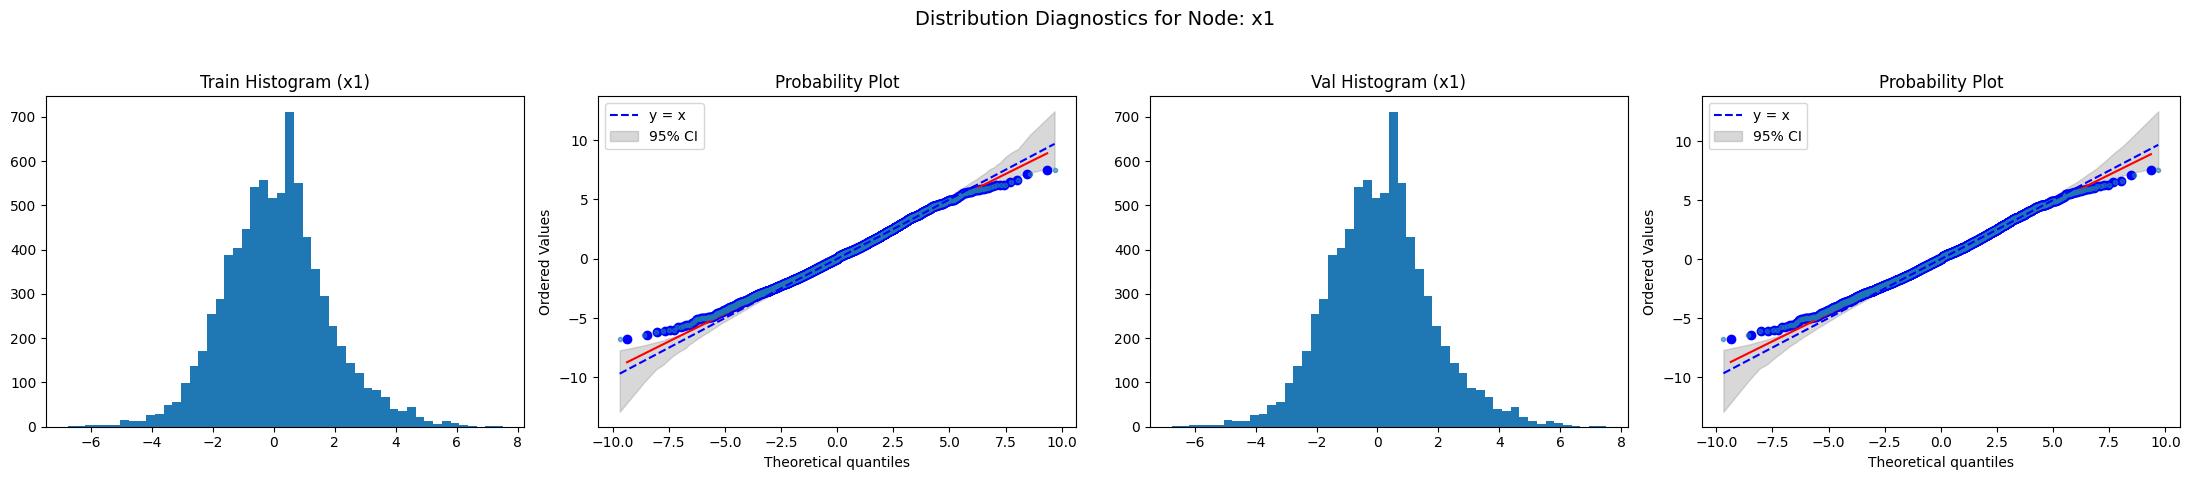


----*----------*-------------*--------h(data) should be standard logistic: x2 ------------*-----------------*-------------------*--


Val loader (x2): 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


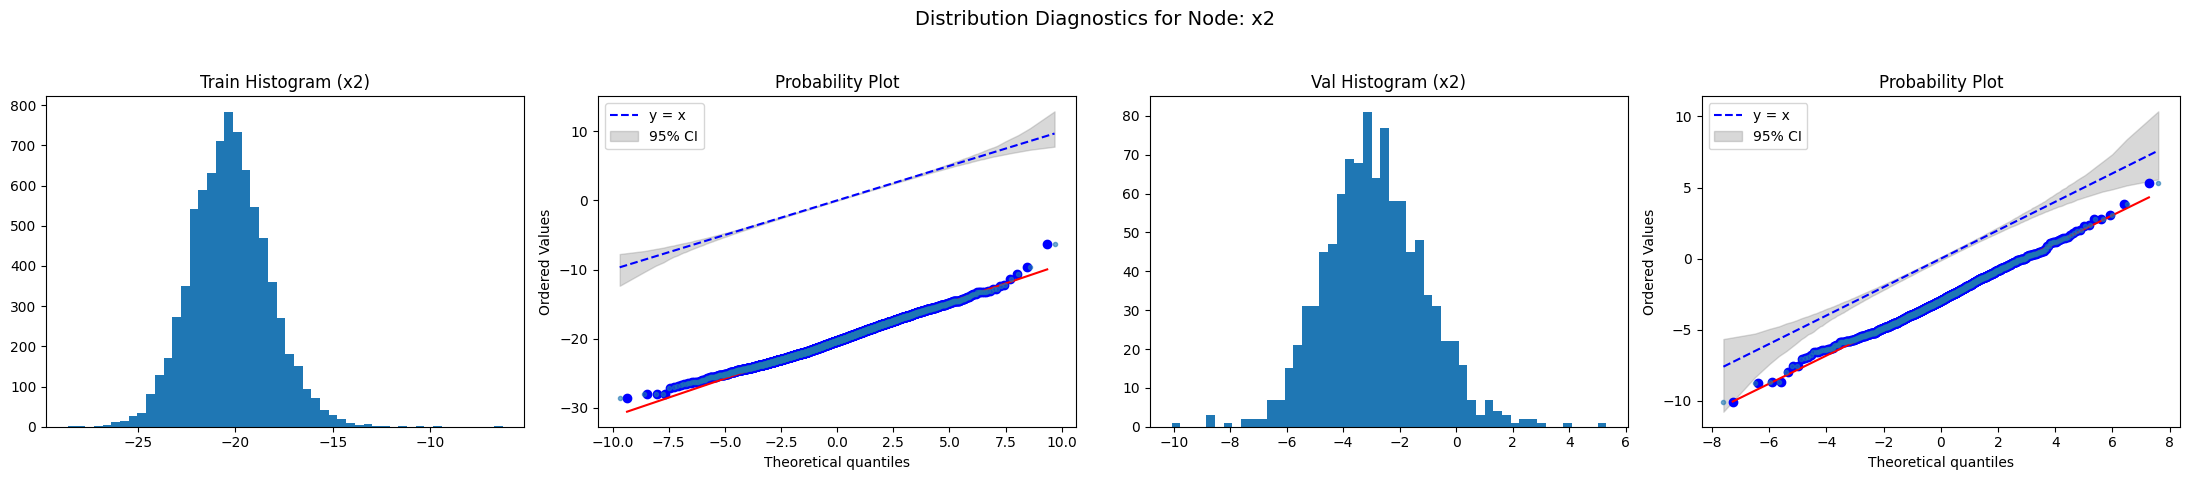


----*----------*-------------*--------h(data) should be standard logistic: x3 ------------*-----------------*-------------------*--


Val loader (x3): 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


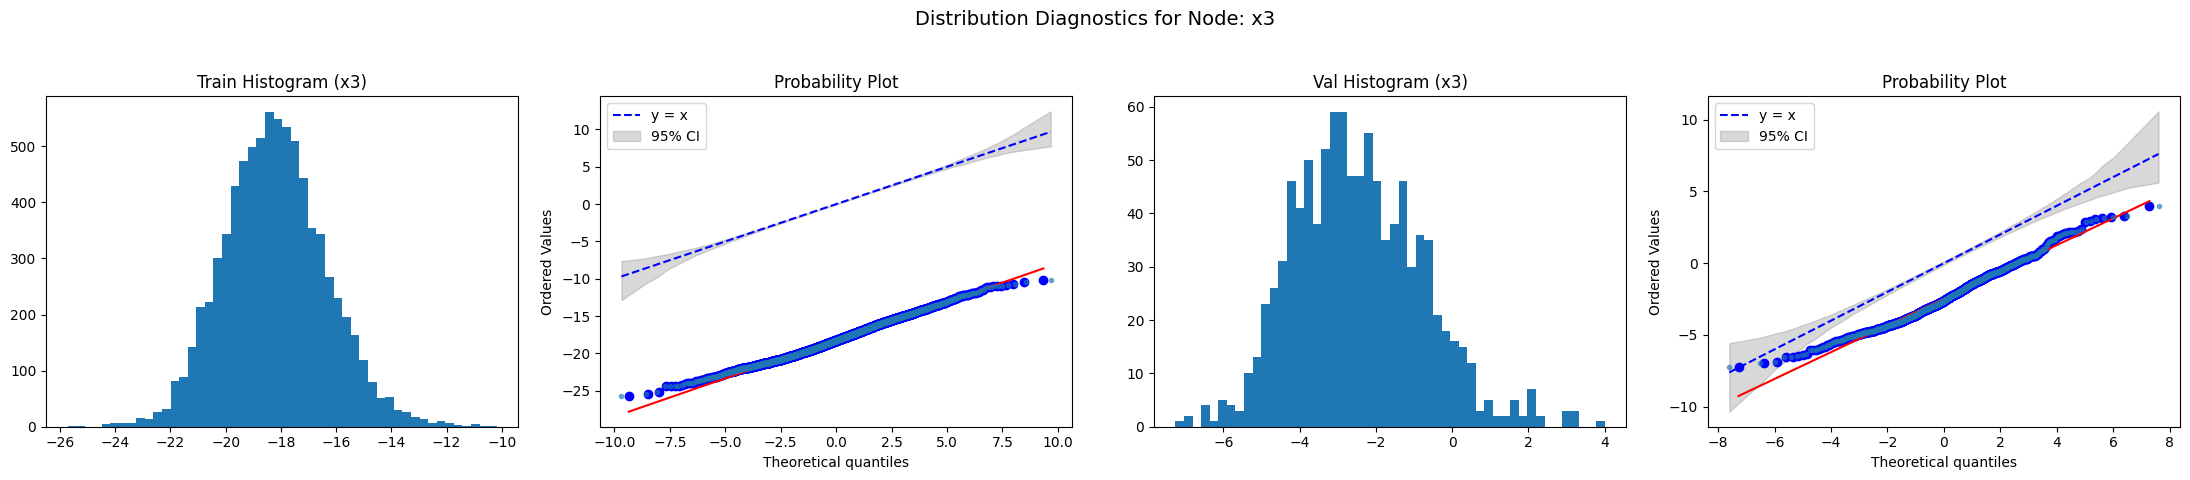

In [12]:
inspect_trafo_standart_logistic(conf_dict,EXPERIMENT_DIR,train_df,val_df,device,verbose=False)

### Coefficients


----*----------*-------------*--------check CS of x1 ------------*-----------------*-------------------*--
Node type : other , is not supported yet

----*----------*-------------*--------check CS of x2 ------------*-----------------*-------------------*--


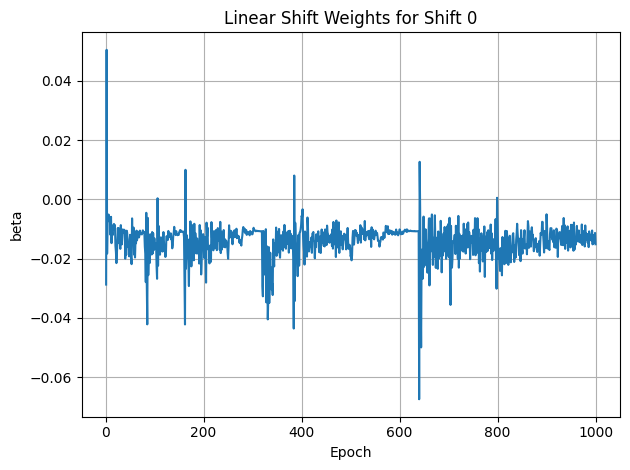


----*----------*-------------*--------check CS of x3 ------------*-----------------*-------------------*--


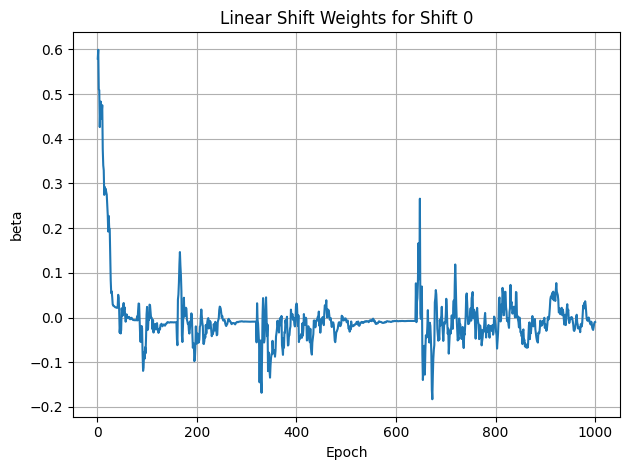

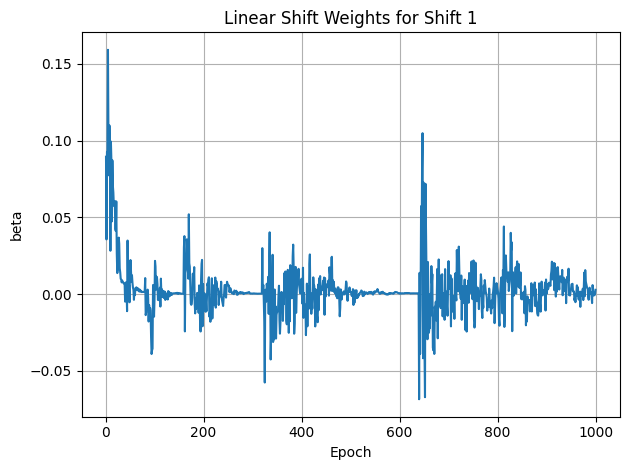

In [13]:
for node in conf_dict:
    print(f'\n----*----------*-------------*--------check CS of {node} ------------*-----------------*-------------------*--')
    
    if (conf_dict[node]['node_type'] == 'source'):
        print(f"Node type : other , is not supported yet")
        continue
    
    
    #### 0. Paths
    NODE_DIR = os.path.join(EXPERIMENT_DIR, f'{node}')
    # Load saved shifts
    shift_path = os.path.join(NODE_DIR, "linear_shifts_all_epochs.json")
    with open(shift_path, 'r') as f:
        all_shift_weights = json.load(f)

    # Sort epochs numerically
    epochs = sorted(all_shift_weights.keys(), key=lambda x: int(x.split('_')[1]))

    # Get number of nodes
    example_epoch = all_shift_weights[epochs[0]]
    num_shifts = len(example_epoch)

    # Plot per node
    for shifts_idx in range(num_shifts):
        shift_name = f"shift_{shifts_idx}"
        weights_over_time = []

        for epoch in epochs:
            weight_matrix = np.array(all_shift_weights[epoch][shift_name])  # shape: [out_features, in_features]
            avg_weight = weight_matrix.mean()  # or use norm, etc.
            # print(epoch,weight_matrix)
            weights_over_time.append(avg_weight)

        plt.figure()
        plt.plot(range(1, len(epochs) + 1), weights_over_time)#, marker='o')
        plt.title(f"Linear Shift Weights for Shift {shifts_idx}")
        plt.xlabel("Epoch")
        plt.ylabel("beta")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [25]:
verbose=False


batch_size = 4112
for node in conf_dict:
    print(f'\n----*----------*-------------*--------check CS of {node} ------------*-----------------*-------------------*--')
    
    if (conf_dict[node]['node_type'] == 'source'):
        print(f"Node type : other , is not supported yet")
        continue
    
    
    #### 0. Paths
    NODE_DIR = os.path.join(EXPERIMENT_DIR, f'{node}')
    
    ##### 1. Load model 
    model_path = os.path.join(NODE_DIR, "best_model.pt")
    tram_model = get_fully_specified_tram_model(node, conf_dict, verbose=verbose)
    tram_model = tram_model.to(device)
    tram_model.load_state_dict(torch.load(model_path))
    tram_model.eval()
    
    # for name, param in tram_model.state_dict().items():
    #     print(f"{name}: {param.data}")
        
    for i in range(len(tram_model.nn_shift)):
        print(tram_model.nn_shift[i].fc.weight.data)
    


----*----------*-------------*--------check CS of x1 ------------*-----------------*-------------------*--
Node type : other , is not supported yet

----*----------*-------------*--------check CS of x2 ------------*-----------------*-------------------*--
tensor([[0.0058]], device='cuda:0')

----*----------*-------------*--------check CS of x3 ------------*-----------------*-------------------*--
tensor([[-0.0011]], device='cuda:0')
tensor([[-0.0001]], device='cuda:0')


In [26]:
conf_dict
EXPERIMENT_DIR
train_df
val_df
device

verbose=False


batch_size = 4112
for node in conf_dict:
    print(f'\n----*----------*-------------*--------check CS of {node} ------------*-----------------*-------------------*--')
    if node != 'x2':
        print('not x2')
        continue
    #### 0. Paths
    NODE_DIR = os.path.join(EXPERIMENT_DIR, f'{node}')
    
    ##### 1. Load model 
    model_path = os.path.join(NODE_DIR, "best_model.pt")
    tram_model = get_fully_specified_tram_model(node, conf_dict, verbose=verbose)
    tram_model = tram_model.to(device)
    tram_model.load_state_dict(torch.load(model_path))
    tram_model.eval()

    ##### 2. Dataloader
    train_loader, val_loader = get_dataloader(node, conf_dict, train_df, val_df, batch_size=batch_size, verbose=verbose)
    
    #### 3. Forward Pass
    min_vals = torch.tensor(conf_dict[node]['min'], dtype=torch.float32).to(device)
    max_vals = torch.tensor(conf_dict[node]['max'], dtype=torch.float32).to(device)
    min_max = torch.stack([min_vals, max_vals], dim=0)

    h_train_list, h_val_list = [], []
    y_pred_list=[]
    with torch.no_grad():
        print("\nProcessing training data...")
        for x, y in tqdm(train_loader, desc=f"Train loader ({node})", total=len(train_loader)):
            y = y.to(device)
            int_input, shift_list = preprocess_inputs(x, device=device)
            
            y_pred = tram_model(int_input=int_input, shift_input=shift_list)
            print(y_pred)
            print(len(shift_list[0]))
            
            break
            # for pred_entry, shift_in in zip(y_pred, shift_list):
            #     pred_entry['shift_out'] = pred_entry['shift_out'] / shift_in  # elementwise division
            #     y_pred_list.append(y_pred)
            
            # h_train, _ = contram_nll(y_pred, y, min_max=min_max, return_h=True)
            # h_train_list.extend(h_train.cpu().numpy())
        # print("\nProcessing validation data...")
        # for x, y in tqdm(val_loader, desc=f"Val loader ({node})", total=len(val_loader)):
        #     y = y.to(device)
        #     int_input, shift_list = preprocess_inputs(x, device=device)
        #     y_pred = tram_model(int_input=int_input, shift_input=shift_list)
        #     h_val, _ = contram_nll(y_pred, y, min_max=min_max, return_h=True)
        #     h_val_list.extend(h_val.cpu().numpy())

# shift_outs = [entry['shift_out'][0].cpu().numpy() for entry in y_pred_list]
# shift_outs_combined = np.vstack(shift_outs)

# y_pred_list


----*----------*-------------*--------check CS of x1 ------------*-----------------*-------------------*--
not x2

----*----------*-------------*--------check CS of x2 ------------*-----------------*-------------------*--

Processing training data...


Train loader (x2):   0%|          | 0/1 [00:00<?, ?it/s]

{'int_out': tensor([[ 0.3831, -1.8523, -2.9061,  ..., -2.8017, -1.7843, -1.8072],
        [ 0.3831, -1.8523, -2.9061,  ..., -2.8017, -1.7843, -1.8072],
        [ 0.3831, -1.8523, -2.9061,  ..., -2.8017, -1.7843, -1.8072],
        ...,
        [ 0.3831, -1.8523, -2.9061,  ..., -2.8017, -1.7843, -1.8072],
        [ 0.3831, -1.8523, -2.9061,  ..., -2.8017, -1.7843, -1.8072],
        [ 0.3831, -1.8523, -2.9061,  ..., -2.8017, -1.7843, -1.8072]],
       device='cuda:0'), 'shift_out': [tensor([[ 3.9365e-03],
        [ 1.0523e-03],
        [ 4.1903e-03],
        [ 2.0054e-03],
        [ 4.2344e-03],
        [ 3.9419e-03],
        [ 3.9993e-03],
        [ 1.3386e-03],
        [ 3.9161e-03],
        [ 4.4177e-03],
        [ 1.1117e-03],
        [ 2.0615e-03],
        [ 1.5032e-03],
        [ 4.4165e-03],
        [ 4.2422e-03],
        [ 7.3748e-04],
        [ 1.9911e-03],
        [ 1.4971e-03],
        [ 1.8344e-03],
        [ 4.1664e-03],
        [ 8.9807e-04],
        [ 4.0929e-03],
        [

In [27]:
## shift betas:

In [28]:
shift_weights = tram_model.nn_shift[0].fc.weight.data
shift_weights

tensor([[0.0058]], device='cuda:0')

In [29]:
y_pred['shift_out'][0].cpu().numpy().squeeze().shape

(800,)

In [30]:
x[1].cpu().numpy().shape

(800,)

In [31]:
y_pred['shift_out'][0]

tensor([[ 3.9365e-03],
        [ 1.0523e-03],
        [ 4.1903e-03],
        [ 2.0054e-03],
        [ 4.2344e-03],
        [ 3.9419e-03],
        [ 3.9993e-03],
        [ 1.3386e-03],
        [ 3.9161e-03],
        [ 4.4177e-03],
        [ 1.1117e-03],
        [ 2.0615e-03],
        [ 1.5032e-03],
        [ 4.4165e-03],
        [ 4.2422e-03],
        [ 7.3748e-04],
        [ 1.9911e-03],
        [ 1.4971e-03],
        [ 1.8344e-03],
        [ 4.1664e-03],
        [ 8.9807e-04],
        [ 4.0929e-03],
        [ 8.8748e-04],
        [ 1.1531e-03],
        [ 1.1412e-03],
        [ 4.4181e-03],
        [ 4.2263e-03],
        [ 4.2427e-03],
        [ 4.4045e-03],
        [ 1.5305e-03],
        [ 4.2120e-03],
        [ 1.5495e-03],
        [ 1.2435e-03],
        [ 4.0293e-03],
        [ 1.8840e-03],
        [ 1.2160e-03],
        [ 1.3732e-03],
        [ 1.4197e-03],
        [ 4.2518e-03],
        [ 2.2307e-03],
        [ 1.1546e-03],
        [ 1.2179e-03],
        [ 1.0999e-03],
        [ 4

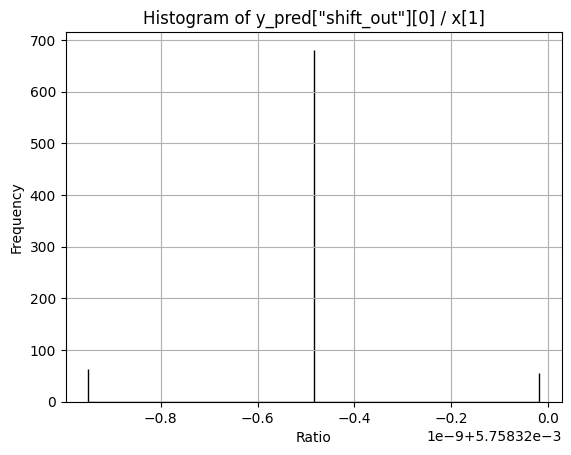

In [32]:
ratio = y_pred['shift_out'][0].cpu().numpy().squeeze()  /x[1].cpu().numpy()
plt.hist(ratio, bins=1000, edgecolor='black')
plt.title('Histogram of y_pred["shift_out"][0] / x[1]')
plt.xlabel('Ratio')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


# 7. Sample from Graph

In [33]:
n = 10_000  # Desired number of latent samples 
batch_size = 1
verbose=True
delete_all_previously_sampled=True

In [34]:
def sample_full_dag_chandru(conf_dict,
                            EXPERIMENT_DIR,
                            device,
                            n= 10_000,
                            batch_size = 32,
                            delete_all_previously_sampled=True,
                            verbose=True):
    

    if delete_all_previously_sampled:
        delete_all_samplings(conf_dict, EXPERIMENT_DIR)
        
    for node in conf_dict:
        print(f'\n----*----------*-------------*--------Sample Node: {node} ------------*-----------------*-------------------*--')
        NODE_DIR = os.path.join(EXPERIMENT_DIR, f'{node}')
        SAMPLING_DIR = os.path.join(NODE_DIR, 'sampling')
        os.makedirs(SAMPLING_DIR, exist_ok=True)
        
        if check_roots_and_latents(NODE_DIR, rootfinder='chandrupatla', verbose=verbose):
            continue
        
        skipping_node = False
        if conf_dict[node]['node_type'] != 'source':
            for parent in conf_dict[node]['parents']:
                if not check_roots_and_latents(os.path.join(EXPERIMENT_DIR, parent), rootfinder='chandrupatla', verbose=verbose):
                    skipping_node = True
                    break
                
        if skipping_node:
            print(f"Skipping {node} as parent {parent} is not sampled yet.")
            continue
        
        min_vals = torch.tensor(conf_dict[node]['min'], dtype=torch.float32).to(device)
        max_vals = torch.tensor(conf_dict[node]['max'], dtype=torch.float32).to(device)
        min_max = torch.stack([min_vals, max_vals], dim=0)
        
        
        latent_sample = torch.tensor(logistic.rvs(size=n), dtype=torch.float32).to(device)
        #latent_sample = truncated_logistic_sample(n=n, low=0, high=1, device=device)
        
        if verbose:
            print("-- sampled latents")
            
        model_path = os.path.join(NODE_DIR, "best_model.pt")
        tram_model = get_fully_specified_tram_model(node, conf_dict, verbose=verbose).to(device)
        tram_model.load_state_dict(torch.load(model_path))
        

            
        if verbose:
            print("-- loaded modelweights")
            
        dataset = SamplingDataset(node=node, EXPERIMENT_DIR=EXPERIMENT_DIR, rootfinder='chandrupatla', number_of_samples=n, conf_dict=conf_dict, transform=None)
        
        
        
        
        sample_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)
        
        output_list = []
        with torch.no_grad():
            for x in tqdm(sample_loader, desc=f"h() for samples in  {node}"):
                x = [xi.to(device) for xi in x]
                int_input, shift_list = preprocess_inputs(x, device=device)
                model_outputs = tram_model(int_input=int_input, shift_input=shift_list)
                output_list.append(model_outputs)
                
        if conf_dict[node]['node_type'] == 'source':
            if verbose:
                print("source node, Defaults to SI and 1 as inputs")
            theta_single = output_list[0]['int_out'][0]
            theta_single = transform_intercepts_continous(theta_single)
            thetas_expanded = theta_single.repeat(n, 1)
            shifts = torch.zeros(n, device=device)
        else:
            if verbose:
                print("node has parents, previously sampled data is loaded for each pa(node)")
            y_pred = merge_outputs(output_list, skip_nan=True)
            shifts = y_pred['shift_out']
            if shifts is None:
                print("shift_out was None; defaulting to zeros.")
                shifts = torch.zeros(n, device=device)
            thetas = y_pred['int_out']
            thetas_expanded = transform_intercepts_continous(thetas).squeeze()
            shifts = shifts.squeeze()
            
        low = torch.full((n,), -1e5, device=device)
        high = torch.full((n,), 1e5, device=device)
        
        ## Root finder using Chandrupatla's method
        def f_vectorized(targets):
            return vectorized_object_function(
                thetas_expanded,
                targets,
                shifts,
                latent_sample,
                k_min=min_max[0],
                k_max=min_max[1]
            )
            
        root = chandrupatla_root_finder(
            f_vectorized,
            low,
            high,
            max_iter=10_000,
            tol=1e-9
        )
        
        ## Saving
        root_path = os.path.join(SAMPLING_DIR, "roots_chandrupatla.pt")
        latents_path = os.path.join(SAMPLING_DIR, "latents.pt")
        
        if torch.isnan(root).any():
            print(f'Caution! Sampling for {node} consists of NaNs')
            
        torch.save(root, root_path)
        torch.save(latent_sample, latents_path)

In [35]:
sample_full_dag_chandru(conf_dict,
                            EXPERIMENT_DIR,
                            device,
                            n= 10_000,
                            batch_size = 1,
                            delete_all_previously_sampled=False,
                            verbose=True)     


----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--

----*----------*-------------*--------Sample Node: x2 ------------*-----------------*-------------------*--

----*----------*-------------*--------Sample Node: x3 ------------*-----------------*-------------------*--


## 7.3 Inspect Sampling

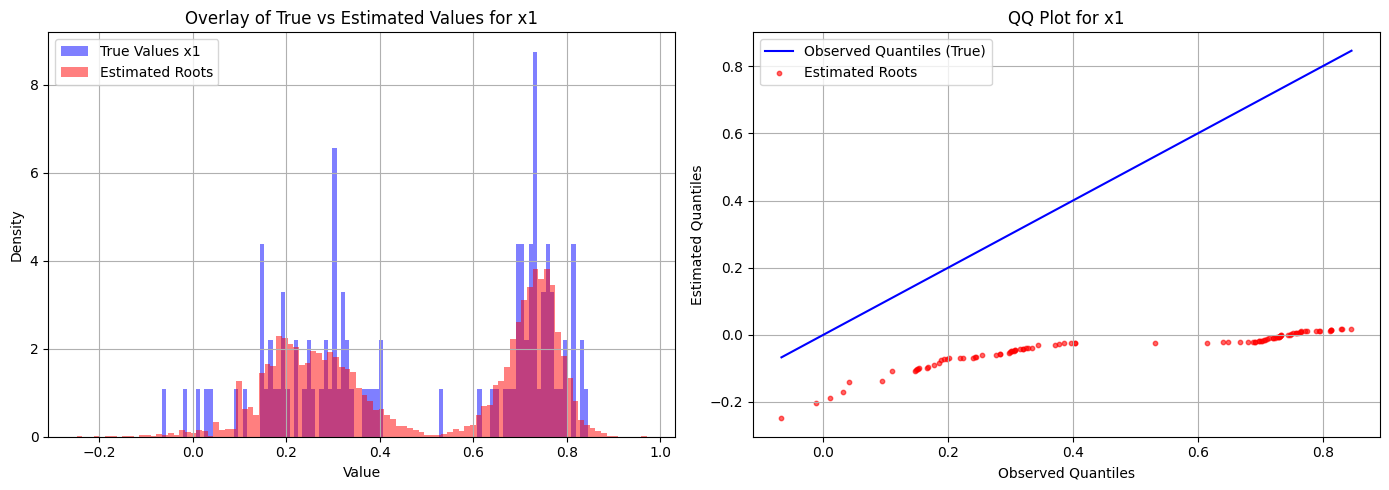

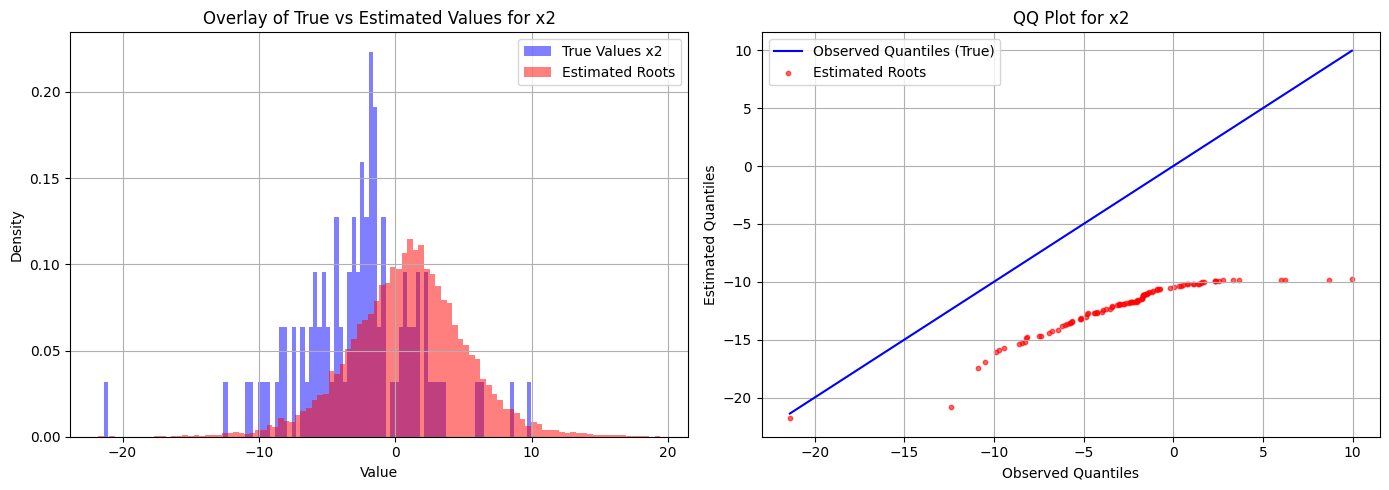

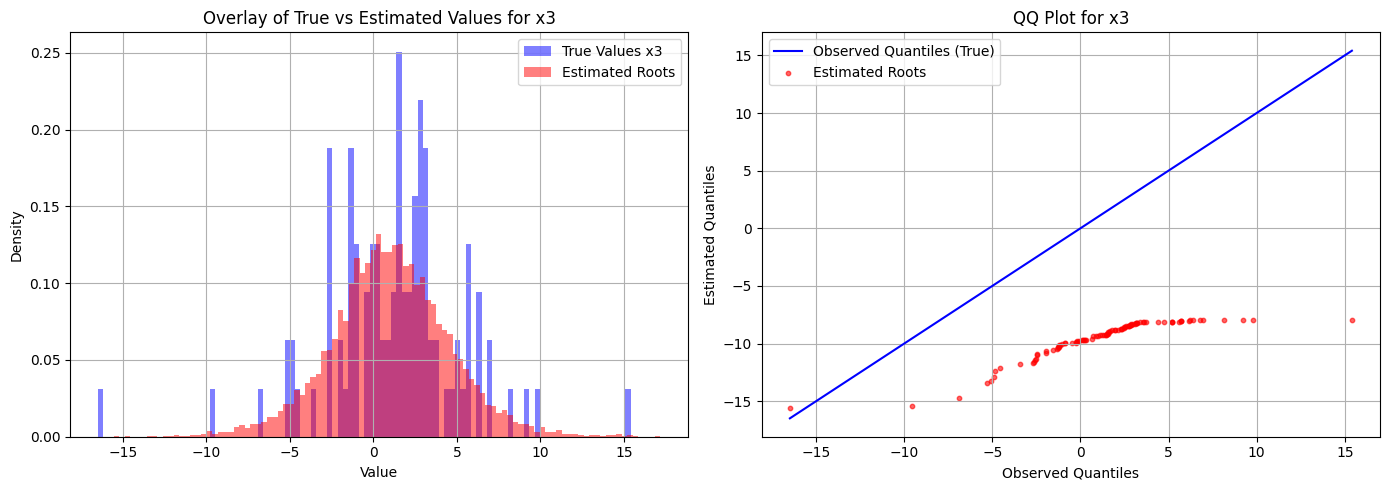

In [36]:
show_samples_vs_true(test_df,conf_dict,EXPERIMENT_DIR,rootfinder='chandrupatla')